In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('INFO')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy import misc

from wfsc import iefc_2dm as iefc
from wfsc import utils

dm_dir = cgi.data_dir/'dm-acts'

dm1_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(dm_dir/'flatmaps'/'hlc_flattened_dm2.fits')

# dm1_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm1.fits')
# dm2_flat = fits.getdata(cgi.dm_dir/'flatmaps'/'hlc_flattened_with_pattern_dm2.fits')

INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


0.00023164260456764313 m


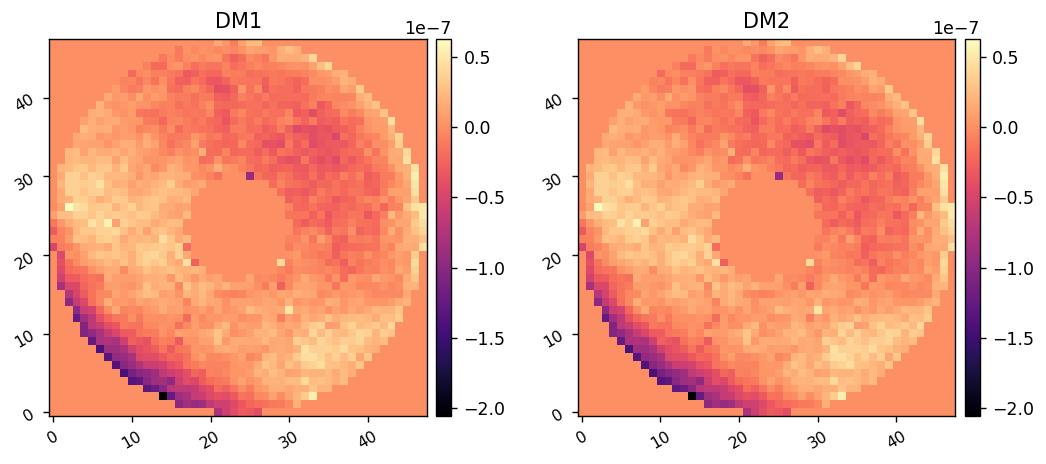

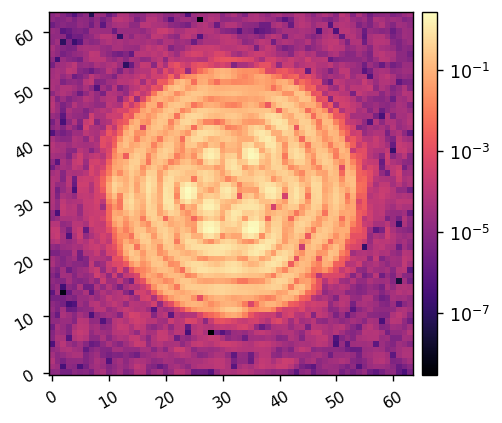

In [2]:
reload(cgi)
sysi = cgi.CGI(cgi_mode='hlc', 
              use_fpm=True,
              use_pupil_defocus=False, 
              polaxis=0,
              use_opds=True,
              dm1_ref=dm1_flat, dm2_ref=dm2_flat,
             )
sysi.show_dms()

npsf = sysi.npsf
Nact = sysi.Nact

ref_psf = sysi.snap()

misc.myimshow(ref_psf, lognorm=True)

# Create dark hole ROI to calibrate and control

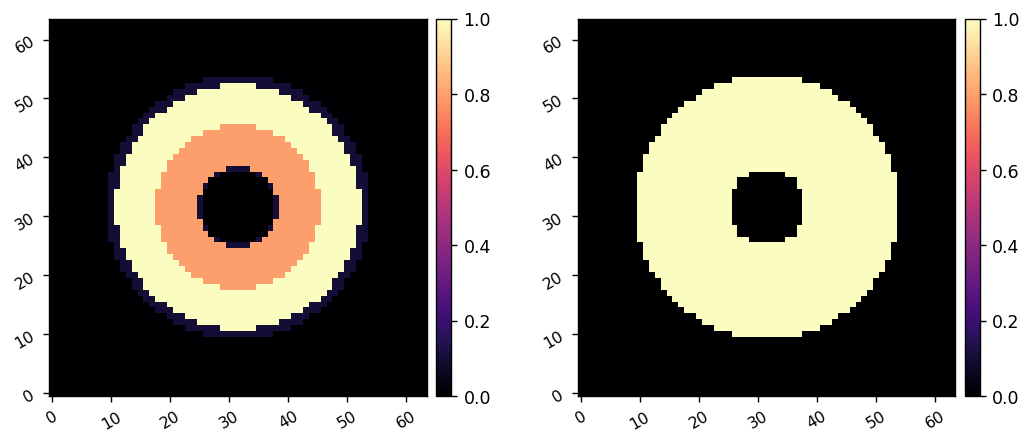

In [3]:
reload(utils)
xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*sysi.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)
fpr = np.sqrt(fpx**2 + fpy**2)
    
iwa = 2.8
owa = 9.7
regions = [iwa, 3, 6, 9, owa]
weights = [0.1, 0.8, 1, 0.1]
weight_map = np.zeros((sysi.npsf,sysi.npsf), dtype=np.float64)
for i in range(len(weights)):
    roi_params = {
        'inner_radius' : regions[i],
        'outer_radius' : regions[i+1],
        'edge_position' : 0,
        'rotation':0,
        'full':True,
    }
    roi = utils.create_annular_focal_plane_mask(fpx, fpy, roi_params)
    weight_map += roi*weights[i]

control_mask = weight_map>0
misc.myimshow2(weight_map, control_mask)

probe_amp = 3e-8
calib_amp = 5e-9

# Create probe and fourier modes

(516, 2304) (258, 2)


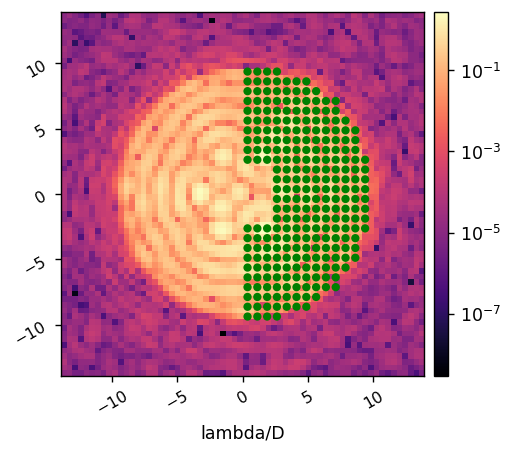

In [4]:
reload(utils)
fourier_modes, fs = utils.select_fourier_modes(sysi, control_mask*(fpx>0), fourier_sampling=0.75) 
nf = fourier_modes.shape[0]
print(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
misc.myimshow(ref_psf, lognorm=True, pxscl=sysi.psf_pixelscale_lamD, patches=patches)

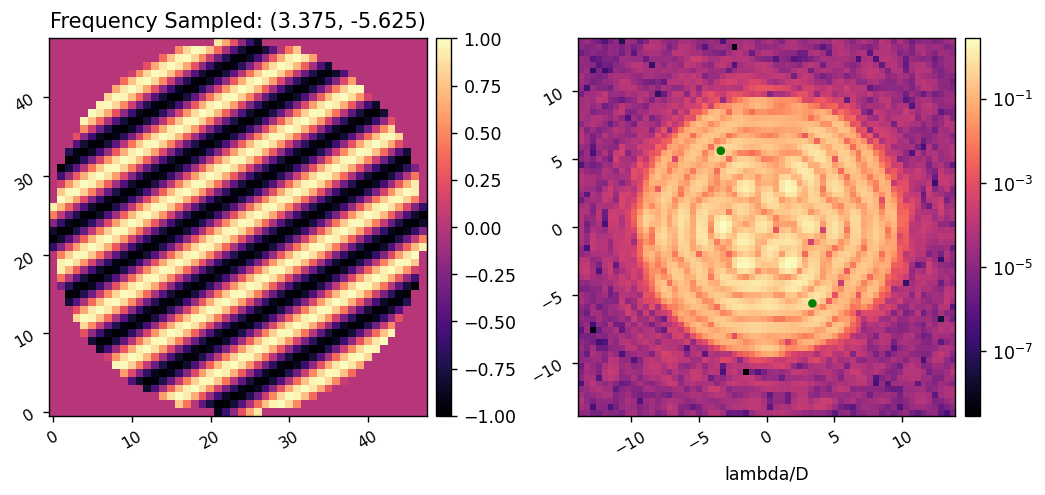

In [5]:
import time
for i in range(nf//2):
    try:
        misc.myimshow2(fourier_modes[i].reshape(Nact,Nact), ref_psf, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=sysi.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

In [13]:
had_modes = utils.get_hadamard_modes_1(sysi.dm_mask)[:1024]
nh = had_modes.shape[0]
print(had_modes.shape)

(1024, 2304)


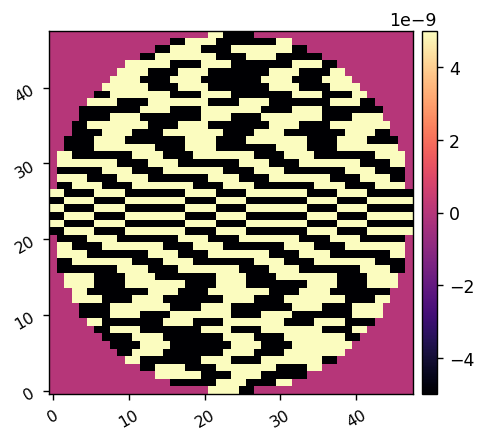

In [7]:
for mode in had_modes:
    try:
        misc.myimshow(calib_amp*mode.reshape(Nact,Nact))
        clear_output(wait=True)
        time.sleep(0.1)
    except KeyboardInterrupt:
        break

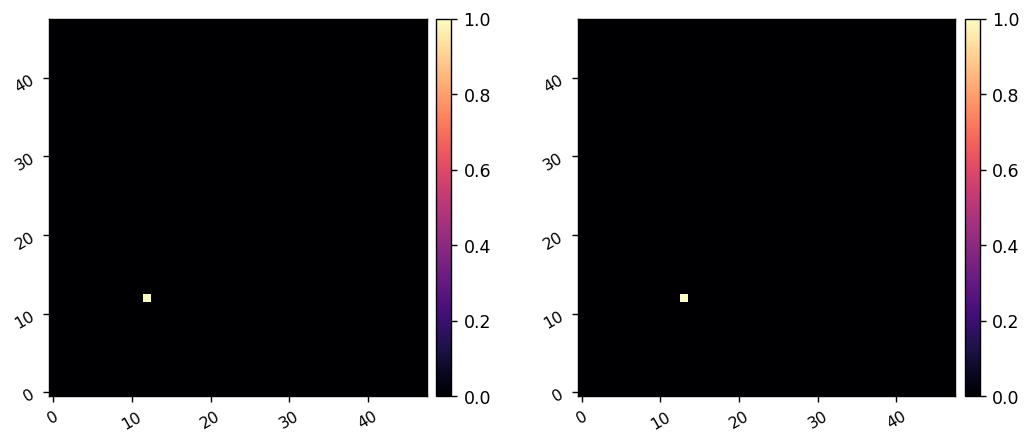

In [6]:
reload(iefc)
probe_modes = utils.create_probe_poke_modes(Nact, xinds=[Nact//4, Nact//4+1], yinds=[Nact//4, Nact//4], display=True)
# probe_modes = utils.create_fourier_probes(calib_modes, display_probes=True)

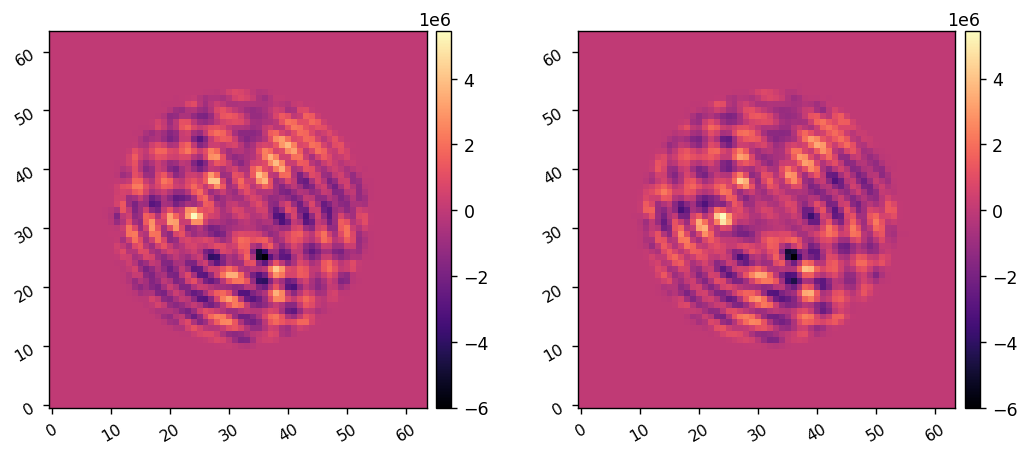

In [9]:
reload(iefc)
sysi.reset_dms()
differential_images, single_images = iefc.take_measurement(sysi, 
                                                           probe_modes, probe_amp, 
                                                           return_all=True, display=True)

# Calibrate IEFC (or load in previous calibration data)

In [15]:
reload(iefc)
sysi.reset_dms()
response_cube, calibration_cube = iefc.calibrate(sysi, 
                                                 probe_amp, probe_modes, 
                                                 calib_amp, fourier_modes, fourier_modes)

Calibrating I-EFC...
	Calibrated mode 1 / 516 in 2.547s
	Calibrated mode 2 / 516 in 5.070s
	Calibrated mode 3 / 516 in 7.590s
	Calibrated mode 4 / 516 in 10.110s
	Calibrated mode 5 / 516 in 12.628s
	Calibrated mode 6 / 516 in 15.149s
	Calibrated mode 7 / 516 in 18.230s
Calibration interrupted.
Calibration complete.


In [10]:
fname = 'hlc_2dm_annular_ff_3-9.pkl'
iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
# iefc_dir = Path('C:/Users/Kian/Documents/data-files/roman-cgi-iefc-data')

In [22]:
misc.save_pickle(iefc_dir/'response-data'/fname, response_cube)
misc.save_pickle(iefc_dir/'calibration-data'/fname, calibration_cube)

Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/hlc_2dm_annular_ff_3-9.pkl
Saved data to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/hlc_2dm_annular_ff_3-9.pkl


In [11]:
response_cube = misc.load_pickle(iefc_dir/'response-data'/fname)
calibration_cube = misc.load_pickle(iefc_dir/'calibration-data'/fname)

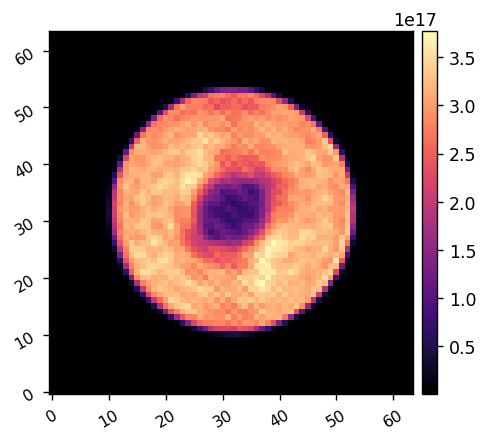

In [12]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64))

# Create control matrix

In [34]:
response_cube.shape, nf, nh

((1540, 2, 4096), 516, 1024)

In [39]:
weight_mask = weight_map.flatten()>0
response_cube[:, :, weight_mask].shape

(1540, 2, 1436)

In [36]:
def construct_control_matrix(response_matrix, 
                             weight_map, 
                             nc1, nc2, 
                             nprobes=2, 
                             rcond1=1e-2, 
                             rcond2=1e-2, 
                             WLS=True, 
                             pca_modes=None):
    weight_mask = weight_map>0
    
    masked_matrix = response_matrix[:, :, weight_mask].reshape((response_matrix.shape[0], -1)).T
    print(masked_matrix.shape)
    
    nmodes = int(response_matrix.shape[0]/2)
    if WLS:
        print('Using Weighted Least Squares ')
        if nprobes==2:
            Wmatrix = np.diag(np.concatenate((weight_map[weight_mask], weight_map[weight_mask])))
        elif nprobes==3:
            Wmatrix = np.diag(np.concatenate((weight_map[weight_mask], weight_map[weight_mask], weight_map[weight_mask])))
        control_matrix_1 = utils.WeightedLeastSquares(masked_matrix[:,:nc1], Wmatrix, rcond=rcond1)
        control_matrix_2 = utils.WeightedLeastSquares(masked_matrix[:,nc1:], Wmatrix, rcond=rcond2)
    else: 
        print('Using Tikhonov Inverse')
        control_matrix_1 = utils.TikhonovInverse(masked_matrix[:,:nc1], rcond=rcond1)
        control_matrix_2 = utils.TikhonovInverse(masked_matrix[:,nc1:], rcond=rcond2)
        
    control_matrix = np.concatenate((control_matrix_1, control_matrix_2), axis=0)
    
    if pca_modes is not None:
        # Return the control matrix minus the pca_mode coefficients
        return control_matrix[0:-pca_modes.shape[0]]
    else:
        return control_matrix

In [40]:
reload(iefc)
control_matrix = construct_control_matrix(response_cube, 
                                                 weight_map.flatten(), 
                                               nc1=nf,
                                               nc2=nh,
                                                 rcond1=1e-1, 
                                                 rcond2=1e-1, 
                                                 nprobes=probe_modes.shape[0], pca_modes=None)
control_matrix.shape, nf, nh, control_mask.sum()*2

(2872, 1540)
Using Weighted Least Squares 


((1540, 2872), 516, 1024, 2872)

In [25]:
reload(iefc)

reg_fun = iefc.construct_control_matrix
reg_conds = [[0, 10, 15, 20],
             [(1e-1, 1e-1), (1e-3, 1e-3), (1e-1, 1e-1), (1e-2, 1e-2)]]

# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 50
(1540,)


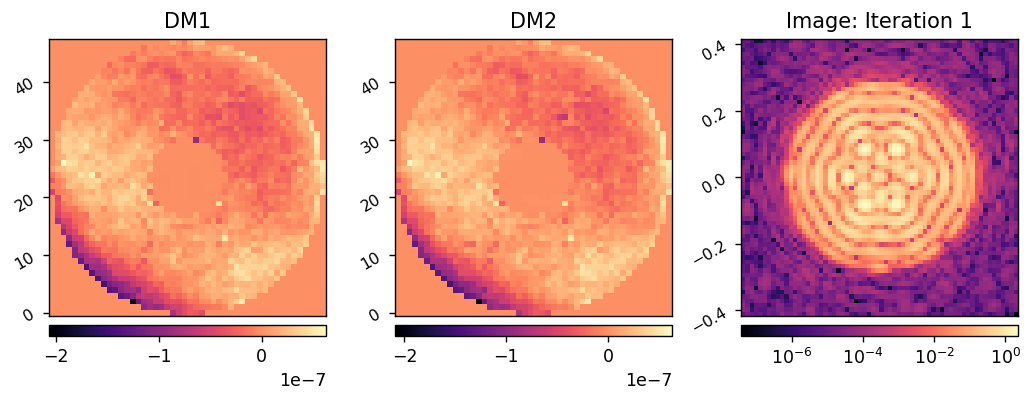

	Closed-loop iteration 2 / 50
(1540,)


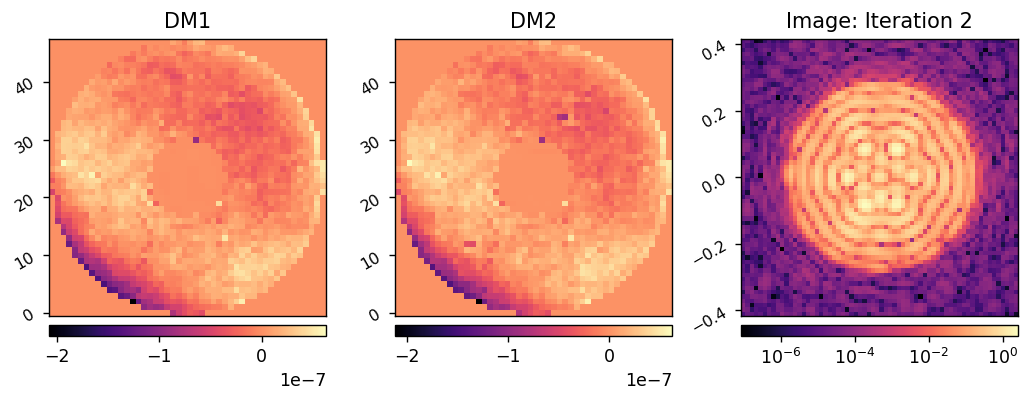

	Closed-loop iteration 3 / 50
(1540,)


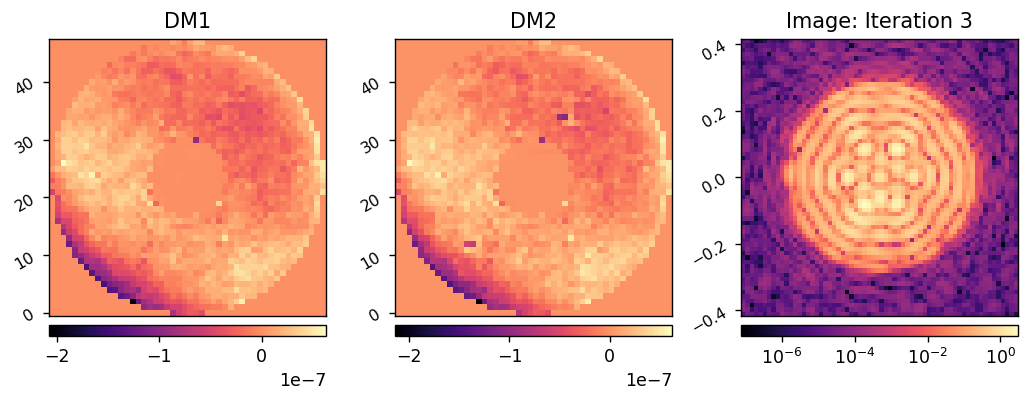

	Closed-loop iteration 4 / 50
(1540,)


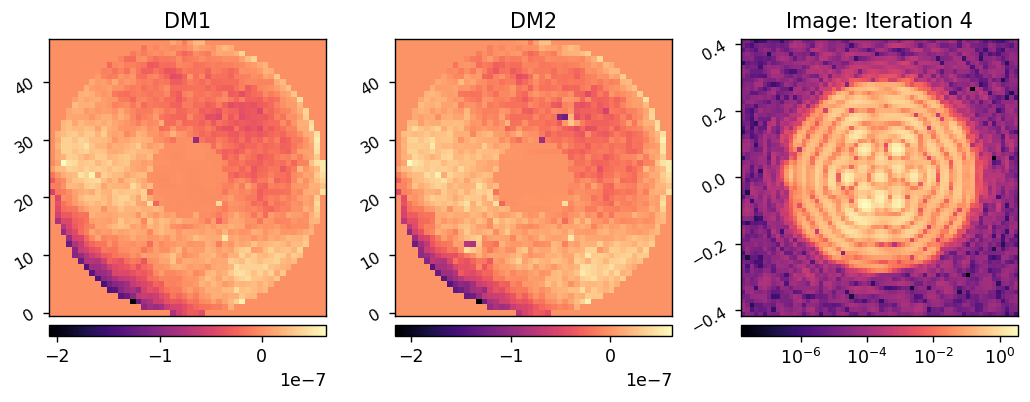

	Closed-loop iteration 5 / 50
(1540,)


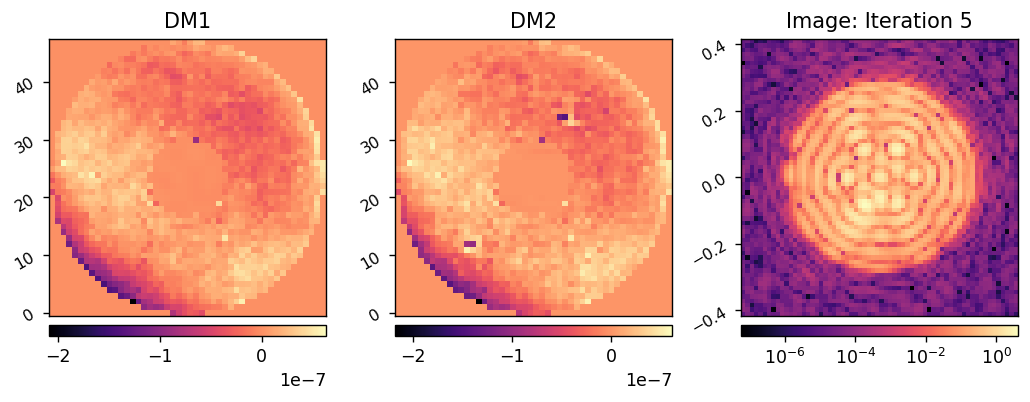

	Closed-loop iteration 6 / 50
(1540,)


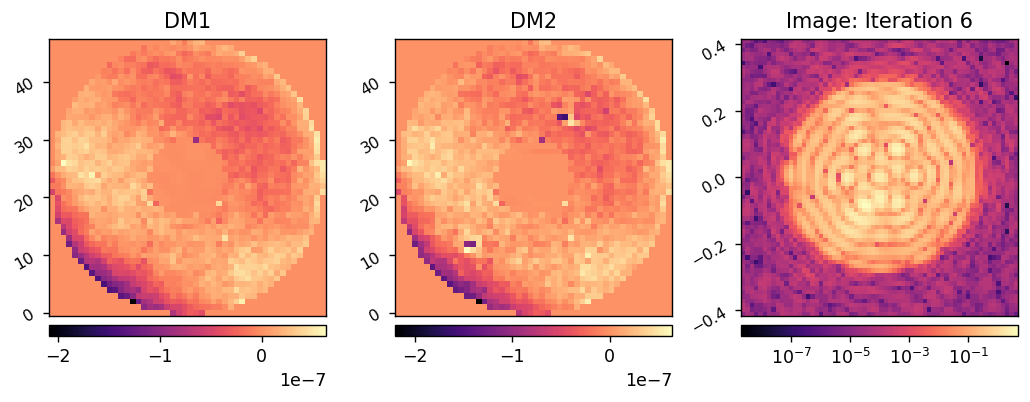

	Closed-loop iteration 7 / 50
(1540,)


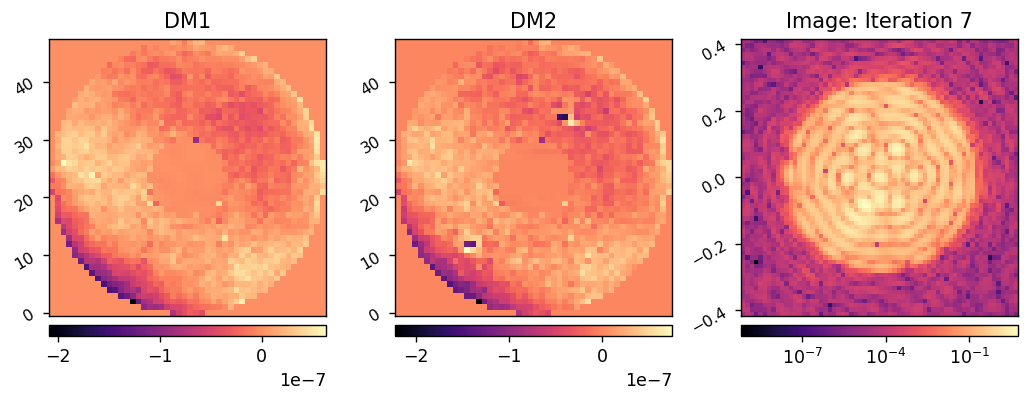

	Closed-loop iteration 8 / 50
(1540,)


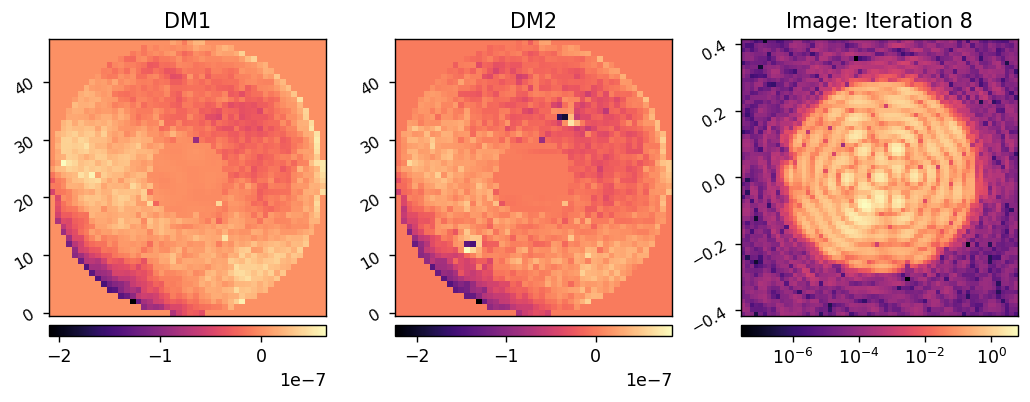

	Closed-loop iteration 9 / 50
(1540,)


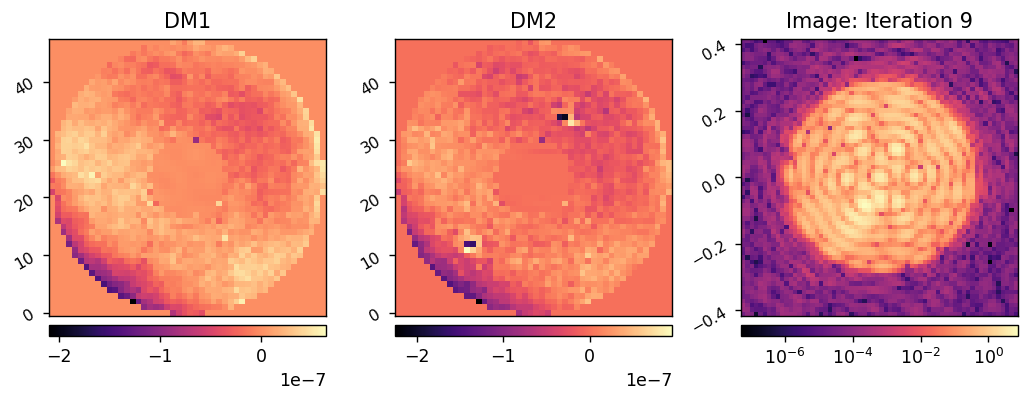

	Closed-loop iteration 10 / 50
(1540,)


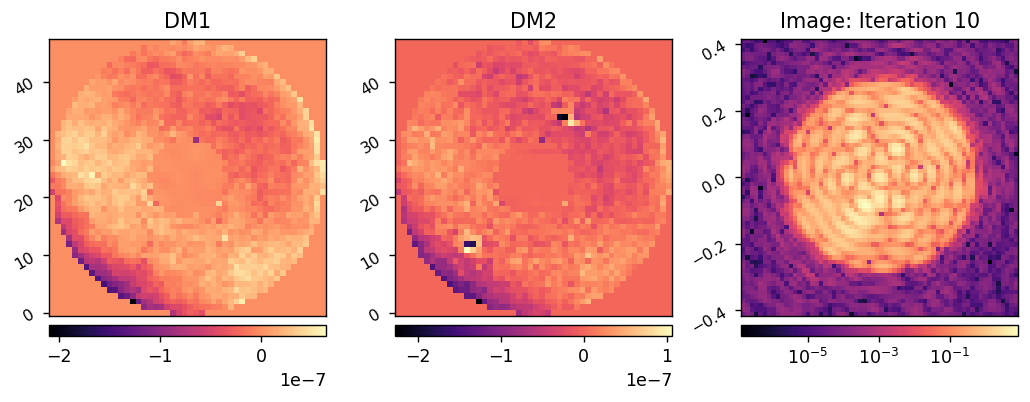

	Closed-loop iteration 11 / 50
(1540,)


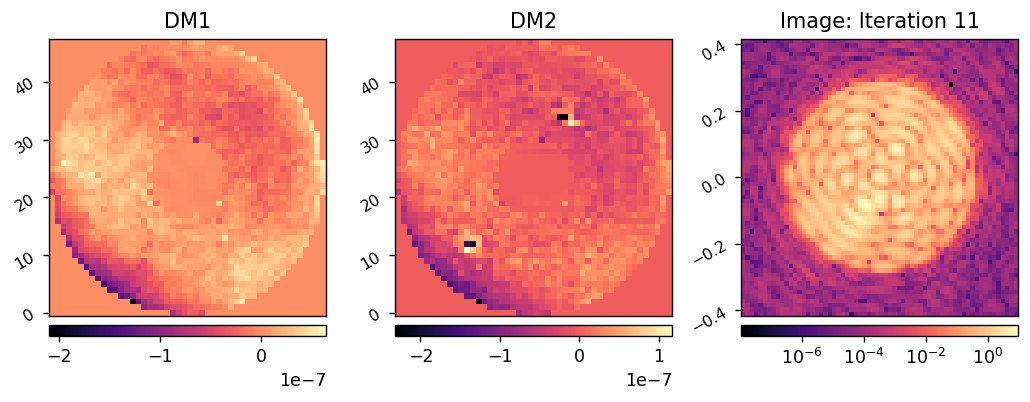

	Closed-loop iteration 12 / 50
(1540,)


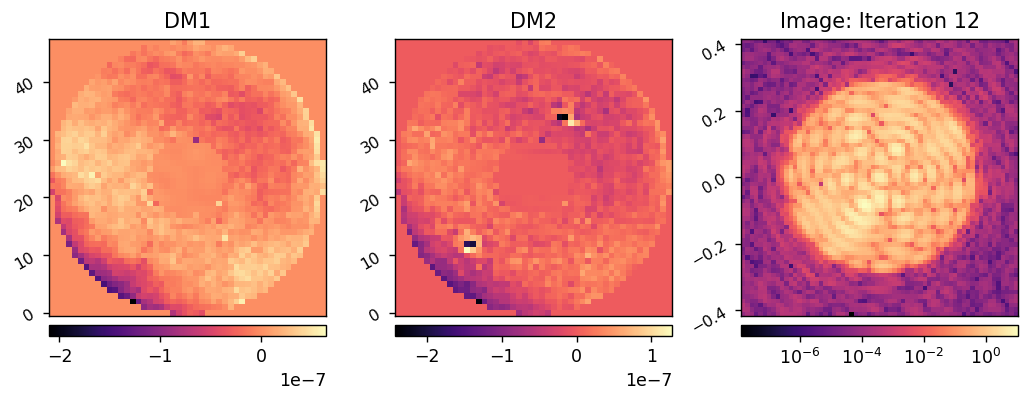

	Closed-loop iteration 13 / 50
(1540,)


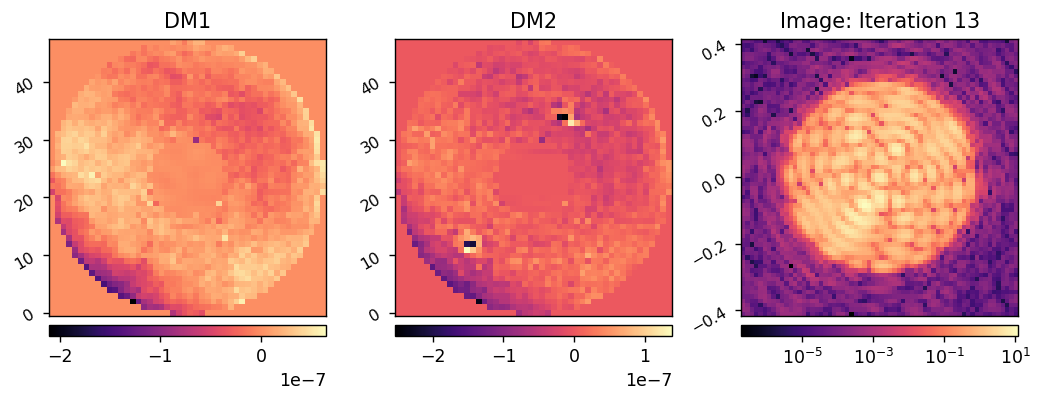

	Closed-loop iteration 14 / 50
(1540,)


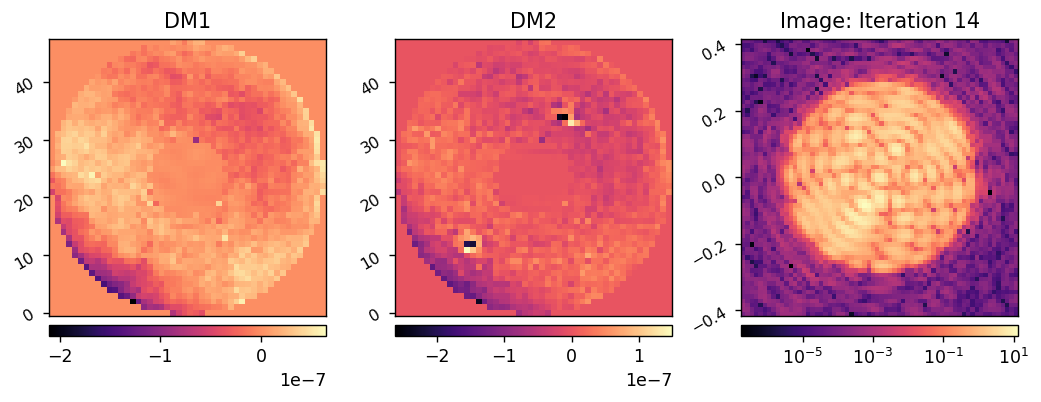

	Closed-loop iteration 15 / 50
(1540,)


KeyboardInterrupt: 

In [41]:
reload(iefc)

sysi.reset_dms()

images, dm1_commands, dm2_commands = iefc.run(sysi, 
                                              control_matrix,
#                                               reg_fun,reg_conds,response_cube, 
                                              probe_modes, 
                                              probe_amp, 
                                              fourier_modes,
                                              had_modes,
                                              weight_map, 
                                              num_iterations=50, 
                                              loop_gain=0.5, leakage=0.0,
                                              display_all=True,
                                             )